In [68]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import statistics as st
%matplotlib inline

In [69]:
dataset_co_cult = np.load('marks_flitered_fluo.npy', allow_pickle = True)

dict_headers = ["norm_MM",
    "cell_marks",
    "nucl_fluo",
    "cell_fluo",
    "marks_fluo",
    "marks_cell_overlap",
    "mark_area",
    "overlap_indices",
    "marks_fluo_overlap",
    "cell_area",
    "marks_cell_overlap_indexes",
    "marks_cellLabels",
    "marks_samplingArea",
    "pmi",
    "overLaps"]

cell_area = dataset_co_cult[9]

# reference, which cells are covered by which marks
cell_marks = dataset_co_cult[1]

# size of every mark
mark_area = dataset_co_cult[6]

# reference of overlap area between cells and marks
marks_cell_overlap = dataset_co_cult[5]



In [70]:
selected_cells = ['3', '100', '21', '43', '547']
cell_marks = {k:v for k,v in cell_marks.items() if k in selected_cells}
cell_area = {k:v for k,v in cell_area.items() if k in selected_cells}
selected_pixels = ['2']
for _, cell in cell_marks.items():
    selected_pixels = selected_pixels + [str(n) for n in cell]

selected_pixels.sort(key = int)
mark_area = {k:v for k,v in mark_area.items() if k in selected_pixels}

selected_pixels

['1', '2', '5', '6', '27', '28', '29', '78', '79', '657']

In [71]:
overlap_matrix = pd.DataFrame(index=[int(n) for n in cell_area.keys()], columns=[int(n) for n in mark_area.keys()])
# this is the ablated region specific sampling proportion
sampling_prop_matrix = overlap_matrix.copy()

for cell_i in cell_marks.keys():
    pixels = cell_marks[cell_i]
    for pixel_i, pixel_loc in enumerate(pixels):
        overlap_matrix.loc[int(cell_i), int(pixel_loc)] = marks_cell_overlap[cell_i][pixel_i]
        sampling_prop_matrix.loc[int(cell_i), int(pixel_loc)] = overlap_matrix.loc[int(cell_i), int(pixel_loc)] / mark_area[pixel_loc]

sampling_prop_matrix
    

,1,2,5,6,27,28,29,78,79,657
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,0.013177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaN,NaN,0.302913,0.302913,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.817133
547,NaN,NaN,NaN,NaN,0.682927,1.0,0.194139,0.043373,0.389432,NaN


In [72]:
total_cell_pixel_overlap = overlap_matrix.sum(axis=1).replace(to_replace=0, value=1)
# this measure serves as weight of the individual contributions of pixels to a cell.
sampling_spec_matrix = overlap_matrix.divide(total_cell_pixel_overlap, axis=0)
sampling_spec_matrix

,1,2,5,6,27,28,29,78,79,657
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaN,NaN,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
547,NaN,NaN,NaN,NaN,0.299096,0.435497,0.087099,0.01479,0.163517,NaN


In [82]:
ion_intensities = pd.read_csv('sm_annotation_detections.csv')
ion_intensities.columns

ion_intensities = ion_intensities[['C16H30O2', "C25H44NO7P", "C45H78NO8P"]]
ion_intensities = ion_intensities.iloc[selected_pixels]

ion_intensities

,C16H30O2,C25H44NO7P,C45H78NO8P
1,459.018520,602.81055,269.30545
2,123.979935,304.60663,0.00000
5,0.000000,279.18823,0.00000
6,137.965130,136.34842,0.00000
27,287.388280,0.00000,0.00000
28,239.394960,83.94426,0.00000
29,0.000000,71.50862,0.00000
78,333.449100,257.37780,318.40220
79,218.720180,0.00000,0.00000
657,480.345100,391.55258,127.76477


In [83]:
# sampling_prop_threshold = 0.3
# sampling_spec_threshold = 0
# 
# pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
# pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold
# 
# sampling_prop_matrix_filtered = sampling_prop_matrix.multiply(pixel_sampling_prop_keep, axis=1)
# sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep
# 
# sampling_prop_matrix_filtered
# 
# norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensities.columns)
# 
# for ion, intensities in ion_intensities.items():
#     inverted_prop_matrix = sampling_prop_matrix_filtered / (sampling_prop_matrix_filtered ** 2)
#     # first, we divide pixel intensities by their respective cell overlaps. That way we get theoretical intensities for a complete pixel-cell overlap
#     norm_spots = inverted_prop_matrix.multiply(intensities, axis=1) 
#     # next we multiply these theoretical intensities with their relative contribution to the total cell-pixels-overlap area
#     weighted_spots = norm_spots * sampling_spec_matrix_filtered
#     # the sum of the individual weighted intensities corresponds to the cell-specific intensity.
#     # finally, these cell-specific intensities are divided by the sum of weights. This important for the situation where weights do not sum up to 1 (filtering)
#     norm_ion_intensities[ion] = norm_spots.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)
# 
# norm_ion_intensities

In [84]:
def cell_normalization_Rappez(sampling_prop_matrix, sampling_spec_matrix, ion_intensity_matrix, sampling_prop_threshold = 0.3, sampling_spec_threshold = 0):
    
    # filter out pixels with little overlap with any cell (thus sum of all overlaps)
    pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
    # filter out pixels with low contributions to a cell
    pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold

    sampling_prop_matrix_filtered = sampling_prop_matrix.multiply(pixel_sampling_prop_keep, axis=1)
    sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep

    # create dataframe for results
    norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensity_matrix.columns)

    for ion, intensities in ion_intensity_matrix.items():
        inverted_prop_matrix = sampling_prop_matrix_filtered / (sampling_prop_matrix_filtered ** 2)
        # first, we divide pixel intensities by their respective cell overlaps. That way we get theoretical intensities for a complete pixel-cell overlap
        norm_spots = inverted_prop_matrix.multiply(intensities, axis=1) 
        # next we multiply these theoretical intensities with their relative contribution to the total cell-pixels-overlap area
        weighted_spots = norm_spots * sampling_spec_matrix_filtered
        # the sum of the individual weighted intensities corresponds to the cell-specific intensity.
        # finally, these cell-specific intensities are divided by the sum of weights. This important for the situation where weights do not sum up to 1 (filtering)
        norm_ion_intensities[ion] = norm_spots.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)

    
    return(norm_ion_intensities)


norm_ion_intensities = cell_normalization_Rappez(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=ion_intensities)


In [85]:
# this is how martijn performed the calculations

# norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensities.columns)
# for ion, intensities in ion_intensities.items():
#     sum_prop_matrix = sampling_prop_matrix_filtered.sum(axis=0).replace(to_replace=0, value=pd.NA)
#     
#     norm_spots = intensities / sum_prop_matrix
#     sums = sampling_spec_matrix_filtered.multiply(norm_spots, axis=1)
#     norm_ion_intensities[ion] = sums.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)
#     
# norm_ion_intensities

In [86]:
ion_intensities

,C16H30O2,C25H44NO7P,C45H78NO8P
1,459.018520,602.81055,269.30545
2,123.979935,304.60663,0.00000
5,0.000000,279.18823,0.00000
6,137.965130,136.34842,0.00000
27,287.388280,0.00000,0.00000
28,239.394960,83.94426,0.00000
29,0.000000,71.50862,0.00000
78,333.449100,257.37780,318.40220
79,218.720180,0.00000,0.00000
657,480.345100,391.55258,127.76477


In [87]:
full_pixels_matrix = sampling_prop_matrix.apply(lambda x: x == 1).sum(axis=0)
full_pixels = full_pixels_matrix[full_pixels_matrix == 1].index

full_pixel_intensities = ion_intensities.apply(lambda x: st.median(x[full_pixels]))

full_pixel_intensities

C16H30O2      239.39496
C25H44NO7P     83.94426
C45H78NO8P      0.00000
dtype: float64

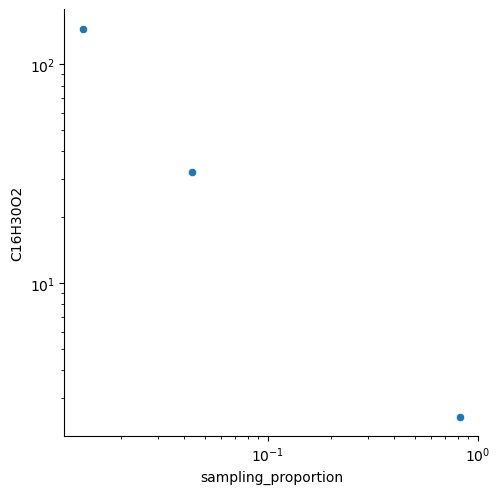

In [111]:
total_pixel_overlap = sampling_prop_matrix.sum(axis=0)
intensity_prop_ratios = ion_intensities.copy().divide(total_pixel_overlap.replace(to_replace=0, value=pd.NA), axis = 0)

norm_intensity_prop_ratios = intensity_prop_ratios.divide(full_pixel_intensities, axis=1)
plot_frame = norm_intensity_prop_ratios.copy()
plot_frame['sampling_proportion'] = total_pixel_overlap

# def log_log_regression_plot(df, molecule = 'C16H30O2'):
#     plot = sns.lmplot(data=plot_frame.dropna().infer_objects(), x='sampling_proportion', y=molecule)
#     plot.set(xscale="log")
#     plot.set(yscale="log")
# 
#     params, _ = quantreg(df)


def log_log_regression_plot(df, molecule = 'C16H30O2'):
    plot = sns.relplot(data=df.dropna().infer_objects(), x='sampling_proportion', y=molecule)
    plot.set(xscale="log")
    plot.set(yscale="log")


log_log_regression_plot(plot_frame)


In [117]:
plot_frame.pop('C45H78NO8P')

1       inf
2      <NA>
5       NaN
6       NaN
27      NaN
28      NaN
29      NaN
78      inf
79      NaN
657     inf
Name: C45H78NO8P, dtype: object

In [138]:
def quantreg(df, reference = 'sampling_proportion'):
    
    if reference not in df.columns:
        raise ValueError('Reference column not found in DataFrame')

    log_df = np.log10(df.dropna().infer_objects())
    log_df = log_df.replace([np.inf, - np.inf], np.nan).dropna()
    correction_factors = log_df.copy()
    params = {}
    predictions = log_df.copy()
    for ion in log_df.columns:
        if ion == reference: continue
        model = smf.quantreg(ion + ' ~ ' + reference, log_df)
        qrmodel = model.fit(q=0.5)
        models[ion] = qrmodel
        params[ion] = qrmodel.params
        reg_correction = 10 ** qrmodel.predict(log_df[[ion, reference]])
        predictions[ion] = df[ion] / reg_correction
        correction_factors[ion] = reg_correction
    
    predictions[reference] = df[reference]
    correction_factors.pop(reference)
    return((models, correction_factors, pd.Series(params), predictions))
    # return(pd.Series(slopes))

models, correction_factors, _, corrected_intensities = quantreg(plot_frame)

In [134]:
plot_intensities.pop('C45H78NO8P')

1      269.30545
2        0.00000
5        0.00000
6        0.00000
27       0.00000
28       0.00000
29       0.00000
78     318.40220
79       0.00000
657    127.76477
Name: C45H78NO8P, dtype: float64

In [155]:
def correct_intensities(raw_value_df, correction_factor_df, reference = 'sampling_proportions'):
    
    ref_series
    if reference in raw_value_df:
        ref_series = raw_value_df.pop(reference)

    corrected_df = raw_value_df / correction_factor_df

    if ref_series != False:
        print(hi)
        corrected_df['reference'] = ref_series
    
    return(corrected_df)

#ion_intensities.pop('C45H78NO8P')
print(ion_intensities)
print(plot_intensities)
print(correction_factors)
print(correct_intensities(ion_intensities, correction_factors))
correct_intensities(plot_intensities, correction_factors)





       C16H30O2  C25H44NO7P
1    459.018520   602.81055
2    123.979935   304.60663
5      0.000000   279.18823
6    137.965130   136.34842
27   287.388280     0.00000
28   239.394960    83.94426
29     0.000000    71.50862
78   333.449100   257.37780
79   218.720180     0.00000
657  480.345100   391.55258
       C16H30O2  C25H44NO7P sampling_proportion
1    459.018520   602.81055            0.013177
2    123.979935   304.60663                   0
5      0.000000   279.18823            0.302913
6    137.965130   136.34842            0.302913
27   287.388280     0.00000            0.682927
28   239.394960    83.94426                 1.0
29     0.000000    71.50862            0.194139
78   333.449100   257.37780            0.043373
79   218.720180     0.00000            0.389432
657  480.345100   391.55258            0.817133
       C16H30O2  C25H44NO7P
1    145.497462  544.916087
6      3.950613    5.686802
28     1.000000    1.000000
78    36.954166   96.233073
657    1.261518    1.341

,C16H30O2,C25H44NO7P,sampling_proportion
1,3.154821,1.106245,NaN
2,NaN,NaN,NaN
5,NaN,NaN,NaN
6,34.922465,23.976290,NaN
27,NaN,NaN,NaN
28,239.394985,83.944269,NaN
29,NaN,NaN,NaN
78,9.023316,2.674525,NaN
79,NaN,NaN,NaN
657,380.767609,291.840228,NaN


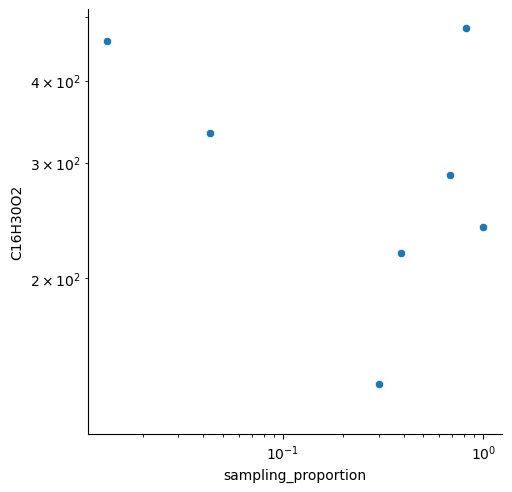

In [127]:
plot_intensities = ion_intensities.copy()
plot_intensities['sampling_proportion'] = total_pixel_overlap
log_log_regression_plot(plot_intensities)